# Phase 2-2: Price blacktesting - long short

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from dateutil import relativedelta
import calendar
import matplotlib.pyplot as plt
from matplotlib import style
from scipy import stats
import statsmodels.api as sm
import math

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def generate_data(formation_date, data_universe, equity_data, bond_data, fama_data, TMT):
    if data_universe == 'IG':
        universe = ['AAA', 'AA', 'A', 'BBB']
    elif data_universe == 'HY':
        universe = ['BB', 'B', 'CCC', 'CC']
    else:
        universe = [data_universe]
    
    #bond
    form_date = datetime.strptime(formation_date, '%Y-%m-%d')
    bcheck_last_day = calendar.monthrange(form_date.year, form_date.month)
    form_date = datetime(form_date.year, form_date.month, bcheck_last_day[-1])
    limitf_date =  form_date + relativedelta.relativedelta(months = 12)
    
    bond_data_ = bond_data[(bond_data.DATE >= form_date) & (bond_data.DATE <= limitf_date) & (bond_data.TMT >= TMT)]
    bond_data_ = bond_data_[bond_data_.RATING_CAT.isin(universe)]
    
    bond_data_ = bond_data_.reset_index()
    bond_data_['form_date'] = form_date
    bond_data_['month'] = (bond_data_.DATE.dt.year - bond_data_.form_date.dt.year)*12 + (bond_data_.DATE.dt.month - bond_data_.form_date.dt.month)
    bcom_list = np.sort(bond_data_[bond_data_['month'] == 1].dropna(subset=['RET_EOM'])['company_symbol'].unique())
    
    #equity
    avg_date =  form_date - relativedelta.relativedelta(months = 12)
    echeck_last_day = calendar.monthrange(avg_date.year, avg_date.month)
    avg_date = datetime(avg_date.year, avg_date.month, echeck_last_day[-1])
    
    equity_data_ = equity_data[(equity_data.date > avg_date) & (equity_data.date <= form_date)]
    equity_data_ = equity_data_.drop_duplicates()
    equity_data_['month_count'] = equity_data_.date.dt.month
    equity_sum_month = equity_data_.groupby('TICKER').agg({'month_count':'count'})
    
    equity_data_ = equity_data_[equity_data_.TICKER.isin(equity_sum_month[equity_sum_month.month_count == 12].index.values)]
       
    equity_data__ = equity_data_[equity_data_.TICKER.isin(bcom_list)]
    ecom_list = np.sort(equity_data__.TICKER.unique())
    del equity_data_
    bond_data__ = bond_data_[bond_data_.company_symbol.isin(ecom_list)]
    bond_data__ = bond_data__[bond_data__.RATING_CAT.isin(universe)]
    del bond_data_
    #fama
    fama_data['dateem'] = pd.to_datetime(pd.PeriodIndex(fama_data.dateff, freq='M').strftime('%Y-%m-%d'), format = '%Y-%m-%d') 
        
    bond_data___ = pd.merge(bond_data__, fama_data[['dateem', 'rf']], how='left', left_on = ['DATE'], right_on=['dateem'])
    bond_data___.YIELD = bond_data___.YIELD.str.replace('%', '').astype('float').divide(100.0)
    bond_data___.RET_EOM = bond_data___.RET_EOM.str.replace('%', '').astype('float').divide(100.0)
    
    equity_data___ = pd.merge(equity_data__, fama_data[['dateff', 'rf']], how='left', left_on = ['date'], right_on=['dateff'])

    return(equity_data___, bond_data___)

In [4]:
def rank_port_decile(equity_data , formation_date, num_month, strat_type = 0):
    
    form_date = datetime.strptime(formation_date, '%Y-%m-%d')
    avg_date =  form_date - relativedelta.relativedelta(months = num_month)
    check_last_day = calendar.monthrange(avg_date.year, avg_date.month)
    avg_date = datetime(avg_date.year, avg_date.month, check_last_day[-1])
    
    equity_data_ = equity_data[(equity_data.date >= avg_date) & (equity_data.date <= form_date)]
    equity_data_ = equity_data_.drop_duplicates()
    try:
        equity_data_ = equity_data_[equity_data_.RETX != 'C']
    except:
        print('There is no C')
    equity_data_.RETX = equity_data_.RETX.astype('float64')
    equity_data_.RET = equity_data_.RET.astype('float64')
    
    #residual
    if strat_type != 0:
        equity_data_.RETX = equity_data_.RETX - equity_data_.rf
    
    equity_group_mean_ret = equity_data_.groupby('TICKER').agg({'RETX': 'mean'})
    equity_group_mean_ret_sort = equity_group_mean_ret.sort_values(by=['RETX'])
    equity_group_mean_ret_sort['GROUP'] = 0
    
    frac = math.floor(equity_group_mean_ret_sort.shape[0]/10)
    num_line = equity_group_mean_ret_sort.shape[0]
    left = num_line-(frac*10)

    group_num = [frac+1]*(left)+[frac]*(10-left)
    group = ['P10', 'P09', 'P08', 'P07', 'P06', 'P05', 'P04', 'P03', 'P02', 'P01']
    
    i, j = 0, group_num[0]
    while j <= num_line:
        
        equity_group_mean_ret_sort.ix[(j-group_num[i]):j , 'GROUP'] = group[i]
        i +=1
        if(i == 10):
            break
        j = j + group_num[i]

    return(equity_group_mean_ret_sort)

In [5]:
def momentum_strategy_price_test(formation_date ,bond_data, rank_port, start_month, end_month, quantity, fee = 0, strat_type = 0):
    
    form_date = datetime.strptime(formation_date, '%Y-%m-%d')
    
    bond_price_ = pd.merge(bond_data, rank_port[['GROUP']], how = 'left', left_on = 'company_symbol', right_index=True)
    bond_price_ = bond_price_.dropna(subset=['RET_EOM'])
    
    bond_price_[bond_price_['PRICE_EOM'].isnull()] = 0
    
    bond_price_.T_DVolume = bond_price_.T_DVolume.str.replace('$', '').str.replace(',', '').astype('float')
    bond_price_month = bond_price_.groupby(['month', 'company_symbol', 'CUSIP', 'GROUP']).agg({'PRICE_EOM':'sum','COUPAMT':'sum', 'COUPACC':'sum','T_DVolume':'sum','COUPON':'mean'})
    bond_price_month_ = pd.DataFrame(columns = ['month', 'ticker', 'cusip','port_group', 'price', 'coupon_amt', 'coupon_acc', 'volume', 'interest'])
    bond_price_month_['month'] = [i[0] for i in bond_price_month.index]
    bond_price_month_['ticker'] = [i[1] for i in bond_price_month.index]
    bond_price_month_['cusip'] = [i[2] for i in bond_price_month.index]
    bond_price_month_['port_group'] = [i[3] for i in bond_price_month.index]
    bond_price_month_['price'] = bond_price_month['PRICE_EOM'].values
    bond_price_month_['coupon_amt'] = bond_price_month['COUPAMT'].values
    bond_price_month_['coupon_acc'] = bond_price_month['COUPACC'].values
    bond_price_month_['volume'] = bond_price_month['T_DVolume'].floordiv(bond_price_month['PRICE_EOM']).values
    bond_price_month_['interest'] = bond_price_month['COUPON'].values/100
    
    bond_hold_price = bond_price_month_[(bond_price_month_.month >= start_month) & (bond_price_month_.month <= end_month)]
    check_month = bond_hold_price.groupby(['cusip','port_group']).agg({'month':'count'})
    check_month['cusip'] = [i[0] for i in check_month.index]
    check_month = check_month[check_month['month'] == check_month['month'].max()]
    bond_list = check_month['cusip'].values
    
    bond_hold_price = bond_hold_price[bond_hold_price['cusip'].isin(bond_list)]
    if(strat_type == 0):
        bond_hold_price_ = bond_hold_price[bond_hold_price['port_group'].isin(['P01', 'P10'])]
    else:
        bond_hold_price_ = bond_hold_price[bond_hold_price['port_group'].isin(['P01'])]
    bond_hold_price_['port_price'] = 0
    
    bond_hold_price_.ix[bond_hold_price_['month'] == start_month, 'port_price'] = bond_hold_price_.ix[bond_hold_price_['month'] == start_month, 'price'] + bond_hold_price_.ix[bond_hold_price_['month'] == start_month, 'coupon_acc']
    bond_hold_price_.ix[bond_hold_price_['month'] == end_month, 'port_price'] = bond_hold_price_.ix[bond_hold_price_['month'] == end_month, 'price'] + bond_hold_price_.ix[bond_hold_price_['month'] == end_month, 'coupon_acc']
    bond_hold_price_.ix[~bond_hold_price_['month'].isin([start_month, end_month]), 'port_price'] = bond_hold_price_.ix[~bond_hold_price_['month'].isin([start_month, end_month]), 'coupon_amt']
    
    bond_hold_price_['quant'] = quantity
    bond_hold_price_['quant_adj'] = 0
    bond_hold_price_.ix[bond_hold_price_['quant'] > bond_hold_price_['volume'], 'quant_adj'] = bond_hold_price_['volume']
    bond_hold_price_.ix[bond_hold_price_['quant'] <= bond_hold_price_['volume'], 'quant_adj'] = bond_hold_price_['quant']
    
    month_list = bond_hold_price_['month'].unique()
    month_list = month_list[1:]
    
    for i in month_list:
        bond_hold_price_.ix[bond_hold_price_['month'] ==  i, 'quant_adj'] = bond_hold_price_.ix[bond_hold_price['month'] ==  start_month, 'quant_adj'].values

    bond_hold_price_['port_price_quant'] = bond_hold_price_['port_price']*bond_hold_price_['quant_adj'] 
    
    if(strat_type == 0):
        if(fee != 0):
            bond_hold_price_.ix[(bond_hold_price_['month'] == end_month) & (bond_hold_price_['port_group'].isin(['P10'])), 'port_price_quant'] = bond_hold_price_.ix[(bond_hold_price_['month'] == end_month) & (bond_hold_price_['port_group'].isin(['P10'])), 'port_price_quant'].values*(1+fee*end_month/12)
            bond_hold_price_.ix[(bond_hold_price_['month'].isin(month_list[:len(month_list)-1])) & (bond_hold_price_['port_group'] == 'P10'), 'port_price_quant'] = bond_hold_price_.ix[(bond_hold_price_['month'].isin(month_list[:len(month_list)-1])) & (bond_hold_price_['port_group'] == 'P10'), 'port_price_quant'].values*(-1*fee/12)
            
        else:
            bond_hold_price_.ix[(bond_hold_price_['month'] == end_month) & (bond_hold_price_['port_group'].isin(['P10'])), 'port_price_quant'] = bond_hold_price_.ix[(bond_hold_price_['month'] == end_month) & (bond_hold_price_['port_group'].isin(['P10'])), 'port_price_quant'].mul(bond_hold_price_.ix[(bond_hold_price_['month'] == end_month) & (bond_hold_price_['port_group'].isin(['P10'])), 'interest'].div(12).mul(end_month*2).add(1))
            bond_hold_price_.ix[(bond_hold_price_['month'].isin(month_list[:len(month_list)-1])) & (bond_hold_price_['port_group'] == 'P10'), 'port_price_quant'] = bond_hold_price_.ix[(bond_hold_price_['month'].isin(month_list[:len(month_list)-1])) & (bond_hold_price_['port_group'] == 'P10'), 'port_price_quant'].mul(bond_hold_price_.ix[(bond_hold_price_['month'].isin(month_list[:len(month_list)-1])) & (bond_hold_price_['port_group'] == 'P10'), 'interest'].div(12).mul(-2))
            
    bond_port_price = bond_hold_price_.groupby(['month', 'port_group']).agg({'port_price_quant':'sum'})
    bond_port_price['month'] = [i[0] for i in bond_port_price.index]
    bond_port_price['port_group'] = [i[1] for i in bond_port_price.index]
    
    bond_port_price['port_price'] = 0
    bond_port_price.ix[(bond_port_price['month'] == start_month) & (bond_port_price['port_group'] == 'P01'), 'port_price_quant'] = bond_port_price.ix[(bond_port_price['month'] == start_month) & (bond_port_price['port_group'] == 'P01'), 'port_price_quant'].mul(-1)
    bond_port_price.ix[(bond_port_price['month'] == end_month) & (bond_port_price['port_group'] == 'P10'), 'port_price_quant'] = bond_port_price.ix[(bond_port_price['month'] == end_month) & (bond_port_price['port_group'] == 'P10'), 'port_price_quant'].mul(-1)

    bond_port_result = bond_port_price.groupby(['month','port_group']).agg({'port_price_quant':'sum'}).unstack(level=0).T
    
    index_name = [form_date + relativedelta.relativedelta(months = i) for i in range(start_month, end_month+1)]
    index_name = [datetime(i.year, i.month, calendar.monthrange(i.year, i.month)[-1]) for i in index_name]
    
    col_name = []
    col_name.append('month')
    for i in bond_port_result.columns.values:
        col_name.append('port_price_{0}'.format(i))
        
    for i in bond_port_result.columns.values:
        col_name.append('port_return_{0}'.format(i))
    
    result = pd.DataFrame(data = 0, columns = col_name, index=index_name)
    result['month'] = range(start_month, end_month+1)
    
    for i in bond_port_result.columns.values:
        result.ix[:, 'port_price_{0}'.format(i)] = bond_port_result.ix[:, i].values
        
    for i in bond_port_result.columns.values:
        result.ix[:end_month, 'port_return_{0}'.format(i)] = bond_port_result.ix[:end_month,i].abs().cumsum().values
        result.ix[end_month:, 'port_return_{0}'.format(i)] = bond_port_result.ix[end_month:,i].abs().values
        result.ix[:, 'port_return_{0}'.format(i)] = result.ix[:, 'port_return_{0}'.format(i)].pct_change()

    list_bond = bond_hold_price_.ix[bond_hold_price_['cusip'].isin(bond_list), ['port_group', 'ticker', 'cusip', 'quant_adj']]
    list_bond['formation_date'] = form_date
    
    return(result, list_bond)

In [12]:
def performance_backtest_price(formation_date, data_universe, avg_range, holding_range, test_period, TMT, capital, quantity, fee = 0, strat_type = 0):

    form_date = datetime.strptime(formation_date, '%Y-%m-%d')
        
    test_list = []
    test_list.append(0)
    for i in range(0, (int(test_period/holding_range[1])-1)):
        test_list.append(test_list[i]+holding_range[1])    
    
    current_form_date = form_date
    
    index_name = [form_date + relativedelta.relativedelta(months = i) for i in range(0, test_period+1)]
    index_name = [datetime(i.year, i.month, calendar.monthrange(i.year, i.month)[-1]) for i in index_name]
    
    perf = pd.DataFrame()
    list_bond = pd.DataFrame()
    
    for i in test_list:

        current_form_date =  form_date + relativedelta.relativedelta(months = i)
        check_last_day = calendar.monthrange(current_form_date.year, current_form_date.month)
        current_form_date = datetime(current_form_date.year, current_form_date.month, check_last_day[-1])
       
        current_equity_data, current_bond_data = generate_data(current_form_date.strftime('%Y-%m-%d'), data_universe, equity_data_raw, bond_data_raw, fama_data_raw, TMT)
        current_rank_port = rank_port_decile(current_equity_data, current_form_date.strftime('%Y-%m-%d'), avg_range, strat_type = strat_type)
        current_perf, bond_l = momentum_strategy_price_test(current_form_date.strftime('%Y-%m-%d'), current_bond_data, current_rank_port, holding_range[0], holding_range[1], quantity, fee, strat_type)
        perf = perf.append(current_perf)
        list_bond = list_bond.append(bond_l)
    
    if(strat_type == 0):
        perf_return = perf.iloc[:, 3:5].dropna()
        perf_return['port_return'] = perf_return.iloc[:,0] - perf_return.iloc[:,1]
        sharpe = (perf_return['port_return'].mean()*np.sqrt(12))/(perf_return['port_return'].std()*(12**(1/2)))
        annual = perf_return['port_return'].add(1).prod()** (12 / len(perf_return['port_return'])) - 1
        max_gain = max(perf.iloc[:,1:3].max().values)
        max_loss = min(perf.iloc[:,1:3].min().values)
        perf['port_price'] = perf['port_price_P01'] + perf['port_price_P10']
        perf['port_price_result'] = perf['port_price']
        perf.ix[0, 'port_price_result'] = perf.ix[0, 'port_price'] + capital
        
        perf_ = perf.reset_index().groupby('index').agg({'port_price_result':'sum'})
        perf_ = perf_.cumsum()
        
    else:
        perf_return = perf.iloc[:,-1].dropna()
        sharpe = (perf_return.mean()*np.sqrt(12))/(perf_return.std()*(12**(1/2)))
        annual = perf_return.add(1).prod()** (12 / len(perf_return)) - 1
        max_gain = perf.iloc[:,1].max()
        max_loss = perf.iloc[:,1].min()
        perf['port_price_result'] = perf['port_price_P01']
        perf.ix[0, 'port_price_result'] = perf.ix[0, 'port_price_P01'] + capital
        
        perf_ = perf.reset_index().groupby('index').agg({'port_price_result':'sum'})
        perf_ = perf_.cumsum()
        
    return(perf_, list_bond, [sharpe, max_gain, max_loss, annual], perf)

In [7]:
def performance_backtest_price_plot(perf_price, list_bond, strat_param, data_universe, avg_range, holding_range, test_period, TMT, capital, quantity):
    
    company_no = list_bond.groupby(['formation_date', 'port_group']).agg({'ticker':'unique'}).reset_index()
    company_no['com_num'] = [len(i) for i in company_no['ticker']]
    company_no.index = company_no['formation_date'].values
    bond_no = list_bond.groupby(['ticker', 'cusip']).agg({'cusip':'unique'})
    bond_no.columns = ['cusip_']
    bond_no = bond_no.reset_index()
    bond_no = bond_no.groupby(['ticker']).agg({'cusip':'count'})
    
    from collections import Counter
    com_list = [i[0] for i in company_no['ticker']]
    com_list = dict(Counter(com_list))
    com_count = pd.DataFrame.from_dict(com_list, orient = 'index')
    com_count.columns=['company_count']
    
    list_bond['month'] = list_bond['formation_date'].dt.month 
    list_bond['year'] = list_bond['formation_date'].dt.year
    
    bond_month = list_bond.groupby(['month', 'year']).agg({'cusip':'unique'}).reset_index()
    bond_month_num = [len(i) for i in bond_month['cusip']]

    style.use('seaborn')
    
    fig = plt.figure(figsize=(18, 15))
    fig.suptitle('Momentum Spillover Performance - {0}: {1} years'.format(data_universe, int(test_period/12)), fontsize=20, fontweight='bold')
    
    plt.figtext(0.5,0.96, "Average {0}-month equity returns \n Holding bond portfolios from {1} to {2} with Time-to-maturity over {3} \n Capital: ${4:,} , Quantity: {5:,} \n Sharpe ratio: {6:.3f}, Annual return {7:.2f}%".format(avg_range, holding_range[0], holding_range[1], TMT, capital, quantity, strat_param[0], strat_param[3]*100), ha="center", va="top", fontsize=15, color="black")
    
    ax1 = plt.subplot2grid((30, 22), (0, 0), rowspan=13, colspan=13)
    ax1.plot(perf_price['port_price_result'], color='SteelBlue')
    ax1.set_title('Momemtum Spillover Back-testing', fontsize=18, weight='bold')
    ax1.annotate("${0:,.1f}".format(perf_price.iloc[-1,0]), xy=(1, perf_price.iloc[-1,0]), xytext=(8, 6), xycoords=('axes fraction', 'data'), textcoords='offset points', fontsize=19, weight='bold')
    
    ax2 = plt.subplot2grid((30, 22), (0, 16), rowspan=13, colspan=6)
        
    index = np.arange(2)
    bar_width = 0.5
    opacity = 0.8

    rect1 = ax2.bar(index, [strat_param[1], strat_param[2]], bar_width, color='SkyBlue')
    for rect in rect1:
        height1 = rect.get_height()
        ax2.text(rect.get_x() + rect.get_width()/2., 1.01*height1,
                    "{0:,.1f}".format(height1),
                    ha='center', va='bottom', fontsize=19, weight='bold')
    ax2.set_ylim([strat_param[2]*1.5, strat_param[1]*1.5])
    ax2.set_title('Max Gain and Loss', fontsize=18, weight='bold')
    ax2.set_xticks(index)
    ax2.set_xticklabels(('Max Gain', 'Max Loss'), fontsize=19, weight='bold')
    
    ax3 = plt.subplot2grid((30, 22), (15, 0), rowspan=8, colspan=22)
    
    index = np.arange(bond_no.shape[0])
    bar_width = 0.5
    opacity = 0.8
    
    rect3 = ax3.bar(index[:100] - bar_width/2, bond_no['cusip'].values[:100], bar_width, color='IndianRed', alpha=opacity, label="Bond_count")
    for rect in rect3:
        height1 = rect.get_height()
        ax3.text(rect.get_x() + rect.get_width()/2., height1,
                    "{0}".format(height1),
                    ha='center', va='bottom', fontsize=15, weight='bold')
    ax3.set_title('Total Companies = {0:,.0f} and Total Bonds = {1:,.0f}, Average Bond/Month = {2:,.0f}'.format(np.count_nonzero(list_bond['ticker'].unique()), np.count_nonzero(list_bond['cusip'].unique()), np.mean(bond_month_num)), fontsize=18, weight='bold')
    ax3.set_xticks(index[:100])
    ax3.set_xticklabels(bond_no.index.values[:100], fontsize=10, rotation=90, weight='bold')
    ax3.legend(fontsize=17)

In [28]:
def performance_backtest_price_year_plot(perf_raw, list_bond, data_universe, avg_range, holding_range, test_period, TMT, quantity, fee = 0, strat_type = 0):

    perf_data = perf_raw
    perf_data['month2'] = perf_data.reset_index()['index'].dt.month.values
    perf_data['year'] = perf_data.reset_index()['index'].dt.year.values
    
    perf_data.ix[(perf_data['month'] == 0) & (perf_data['month2'] == 12),'month2'] = 0
    perf_data.ix[perf_data['month2'] == 0, 'year'] = perf_data.ix[(perf_data['month'] == 1) & (perf_data['month2'] == 12),'year'].values
    
    perf_data['port_price_cumsum'] = perf_data.groupby(['year'])['port_price_result'].apply(lambda x: x.cumsum())
    if(strat_type == 0):
        perf_data['port_return'] = perf_data['port_return_P01'].fillna(0) - perf_data['port_return_P10'].fillna(0)
    else:
        perf_data['port_return'] = perf_data['port_return_P01'].fillna(0)
        
    perf_data['port_return_cumprod'] = perf_data.add(1).groupby(['year'])['port_return'].apply(lambda x: x.cumprod())
    perf_data['port_return_cumprod'] = perf_data['port_return_cumprod'].subtract(1)
    
    perf_ypl = perf_data.ix[perf_data['month2'] == 12,'port_price_cumsum']
    perf_yreturn = perf_data.ix[perf_data['month2'] == 12,'port_return_cumprod']
    
    perf_sharpe = perf_data.ix[perf_data['port_return'] != 0,:].groupby(['year'])['port_return'].apply(lambda x: x.mean()/x.std())
    ##
    if(strat_type == 0):
        perf_max = perf_raw.groupby(['year'])[['port_price_P01', 'port_price_P10']].apply(lambda x: x.max()).max(axis=1)
        perf_min = perf_raw.groupby(['year'])[['port_price_P01', 'port_price_P10']].apply(lambda x: x.min()).min(axis=1)
        strate_name = 'Long-Short'
    else:
        perf_max = perf_raw.groupby(['year'])[['port_price_P01']].apply(lambda x: x.max()).max(axis=1)
        perf_min = perf_raw.groupby(['year'])[['port_price_P01']].apply(lambda x: x.min()).min(axis=1)
        fee = 0
        strate_name = 'Long-Only'
        
    list_bond['month'] = list_bond['formation_date'].dt.month 
    list_bond['year'] = list_bond['formation_date'].dt.year
    
    bond_month = list_bond.groupby(['month', 'year']).agg({'cusip':'unique'}).reset_index()
    bond_month['bond_count'] = [len(i) for i in bond_month['cusip']]
    bond_month_num = bond_month.groupby(['year']).agg({'bond_count':'mean'})
    
    bond_year = list_bond.groupby(['year']).agg({'cusip':'unique'}).reset_index()
    bond_year_num = [len(i) for i in bond_year['cusip']]
    
    index_name = perf_max.index.values
    
    perf_year = pd.DataFrame(index=index_name)
    perf_year['port_pl'] = perf_ypl.values
    perf_year['port_return'] = perf_yreturn.values
    perf_year['port_sharpe'] = perf_sharpe.values
    perf_year['port_max'] = perf_max.values
    perf_year['port_min'] = perf_min.values
    perf_year['port_monthyear'] = bond_month_num.values[1:]
    perf_year['port_year'] = bond_year_num[1:]
    
    spy_data_raw = pd.read_csv('SPY_data.csv')
    spy_data_raw.date = pd.to_datetime(spy_data_raw.date, format = '%Y%m%d')
    
    start_date = datetime.strptime('2003-12-31', '%Y-%m-%d')
    end_date = datetime.strptime('2016-12-31', '%Y-%m-%d')
    
    spy_data = spy_data_raw[(spy_data_raw.date >= start_date) & (spy_data_raw.date <= end_date)]
    
    spy_data['month'] = spy_data.date.dt.month
    spy_data['year'] = spy_data.date.dt.year
    perf_ben_syear = spy_data.groupby(['year'])['PRC'].apply(lambda x: x.head(1))
    perf_ben_lyear = spy_data.groupby(['year'])['PRC'].apply(lambda x: x.tail(1))
    
    perf_ben_year = pd.DataFrame(index = perf_ben_syear.reset_index()['year'].values)
    perf_ben_year['ben_sprice'] = perf_ben_syear.values
    perf_ben_year['ben_lprice'] = perf_ben_lyear.values
    perf_ben_year['ben_dprice'] = perf_ben_year['ben_lprice'].values - perf_ben_year['ben_sprice'].values
    perf_ben_year['ben_price'] = perf_ben_year['ben_dprice']*quantity
    perf_ben_year['ben_return'] = perf_ben_year['ben_lprice'].div(perf_ben_year['ben_sprice']).subtract(1)
    perf_ben_year['ben_sharpe'] = spy_data.groupby(['year'])['RETX'].apply(lambda x: x.mean()/x.std()).fillna(0)
    
    style.use('seaborn')
    
    fig = plt.figure(figsize=(18, 15))
    fig.suptitle('{0} Momentum Spillover Performance - {1}: {2} years'.format(strate_name, data_universe, int(test_period/12)), fontsize=20, fontweight='bold')
    plt.figtext(0.5,0.96, "Average {0}-month equity returns \n Holding bond portfolios from {1} to {2} with Time-to-maturity over {3} \n Quantity: {4:,}, Shorting fee {5:,.2f} %".format(avg_range, holding_range[0], holding_range[1], TMT, quantity, fee*100), ha="center", va="top", fontsize=15, color="black")
        
    ax1 = plt.subplot2grid((60, 22), (0, 0), rowspan=15, colspan=22)
    
    index = np.arange(perf_year.shape[0])
    bar_width = 0.35
    opacity = 0.8
    
    rect11 = ax1.bar(index - bar_width/2, perf_year['port_pl'].round(2).values, bar_width, color='IndianRed', alpha=opacity, label='P&L Strategy: Total = ${0:,.2f}'.format(perf_year['port_pl'].sum()))
    for rect in rect11:
        height1 = rect.get_height()
        ax1.text(rect.get_x() + rect.get_width()/2, height1,
                    "{0:,.1f}".format(height1),
                    ha='center', va='bottom', fontsize=15, weight='bold', rotation=45)
        
    rect12 = ax1.bar(index + bar_width/2, perf_ben_year['ben_price'].round(2).values[1:], bar_width, color='SkyBlue', alpha=opacity, label='P&L Benchmark: Total = ${0:,.2f}'.format(perf_ben_year['ben_price'].sum()))
    for rect in rect12:
        height1 = rect.get_height()
        ax1.text(rect.get_x() + rect.get_width()/2, height1,
                    "{0:,.1f}".format(height1),
                    ha='center', va='bottom', fontsize=12, weight='bold', rotation=45)
    ax1.set_ylim([perf_year['port_pl'].min()*1.5, perf_year['port_pl'].max()*2])
    ax1.set_title('Net P&L per Year between Strategy and SPY Benchmark', fontsize=19, weight='bold')
    ax1.set_xticks(index)
    ax1.set_xticklabels(perf_year.index.values, fontsize=17)
    ax1.legend(fontsize=15)
    
    ax2 = plt.subplot2grid((60, 22), (19, 0), rowspan=10, colspan=22)
    
    index = np.arange(perf_year.shape[0])
    bar_width = 0.35
    opacity = 0.8
    
    rect21 = ax2.bar(index - bar_width/2, perf_year['port_return'].round(2).values, bar_width, color='IndianRed', alpha=opacity, label='Annual Return Strategy')
    for rect in rect21:
        height1 = rect.get_height()
        ax2.text(rect.get_x() + rect.get_width()/2, 0.95*height1,
                    "{0:,.0f}%".format(height1*100),
                    ha='center', va='bottom', fontsize=15, weight='bold')
        
    rect22 = ax2.bar(index + bar_width/2, perf_ben_year['ben_return'].round(2).values[1:], bar_width, color='SkyBlue', alpha=opacity, label='Annual Return Benchmark')
    for rect in rect22:
        height1 = rect.get_height()
        ax2.text(rect.get_x() + rect.get_width()/2, 0.95*height1,
                    "{0:,.0f}%".format(height1*100),
                    ha='center', va='bottom', fontsize=12, weight='bold')
    ax2.set_ylim([perf_ben_year['ben_return'].min()*1.5, perf_year['port_return'].max()*1.5])
    ax2.set_title('Annual Return per Year between Strategy and SPY Benchmark', fontsize=19, weight='bold')
    ax2.set_xticks(index)
    ax2.set_xticklabels(perf_year.index.values, fontsize=17)
    ax2.legend(fontsize=15)
    
    ax3 = plt.subplot2grid((60, 22), (33, 0), rowspan=10, colspan=22)
    
    index = np.arange(perf_year.shape[0])
    bar_width = 0.35
    opacity = 0.8
    
    rect31 = ax3.bar(index - bar_width/2, perf_year['port_sharpe'].round(2).values, bar_width, color='IndianRed', alpha=opacity, label='Sharpe Ratio Strategy')
    for rect in rect31:
        height1 = rect.get_height()
        ax3.text(rect.get_x() + rect.get_width()/2, height1,
                    "{0:,.2f}".format(height1),
                    ha='center', va='bottom', fontsize=15, weight='bold')
        
    rect32 = ax3.bar(index + bar_width/2, perf_ben_year['ben_sharpe'].round(2).values[1:], bar_width, color='SkyBlue', alpha=opacity, label='Sharpe Ratio Benchmark')
    for rect in rect32:
        height1 = rect.get_height()
        ax3.text(rect.get_x() + rect.get_width()/2, height1,
                    "{0:,.2f}".format(height1),
                    ha='center', va='bottom', fontsize=12, weight='bold')
    ax3.set_ylim([perf_ben_year['ben_sharpe'].min()*1.5, perf_year['port_sharpe'].max()*2])
    ax3.set_title('Sharpe Ratio per Year between Strategy and SPY Benchmark', fontsize=19, weight='bold')
    ax3.set_xticks(index)
    ax3.set_xticklabels(perf_year.index.values, fontsize=17)
    ax3.legend(fontsize=15)
    
    ax4 = plt.subplot2grid((60, 22), (47, 0), rowspan=10, colspan=22)
    
    index = np.arange(perf_year.shape[0])
    bar_width = 0.35
    opacity = 0.8
    
    rect41 = ax4.bar(index - bar_width/2, perf_year['port_monthyear'].round(2).values, bar_width, color='orchid', label='Average Bond per Month')
    for rect in rect41:
        height1 = rect.get_height()
        ax4.text(rect.get_x() + rect.get_width()/2, height1,
                    "{0:,.0f}".format(height1),
                    ha='center', va='bottom', fontsize=15, weight='bold')
        
    rect42 = ax4.bar(index + bar_width/2, perf_year['port_year'].round(2).values, bar_width, color='turquoise', alpha=opacity, label='Total Bond per Year')
    for rect in rect42:
        height1 = rect.get_height()
        ax4.text(rect.get_x() + rect.get_width()/2, height1,
                    "{0:,.0f}".format(height1),
                    ha='center', va='bottom', fontsize=15, weight='bold')
    ax4.set_ylim([0, perf_year['port_year'].max()*1.5])
    ax4.set_title('Strategy Bond Summary', fontsize=19, weight='bold')
    ax4.set_xticks(index)
    ax4.set_xticklabels(perf_year.index.values, fontsize=17)
    ax4.legend(fontsize=15)

# Import data

In [9]:
bond_data_raw = pd.read_csv('bond_data.txt', sep='\t')
bond_data_raw.DATE = pd.to_datetime(bond_data_raw.DATE, format = '%d%b%Y')

equity_data_raw = pd.read_csv('equity_data.txt', sep='\t')
equity_data_raw.date = pd.to_datetime(equity_data_raw.date, format = '%Y%m%d')

fama_data_raw = pd.read_csv('fama_data.txt', sep='\t')
fama_data_raw.dateff = pd.to_datetime(fama_data_raw.dateff, format = '%Y%m%d')

# Backtesting

# Shorting fee: 2.5%

In [17]:
formation_date = '2003-12-31'
avg_range = 3
strat_type = 0
holding_range = (0, 1)

test_period = 12*13
capital = 0
quantity = 100
fee = 2.5/100

# IG universe

In [34]:
TMT = 28
data_universe = 'IG'

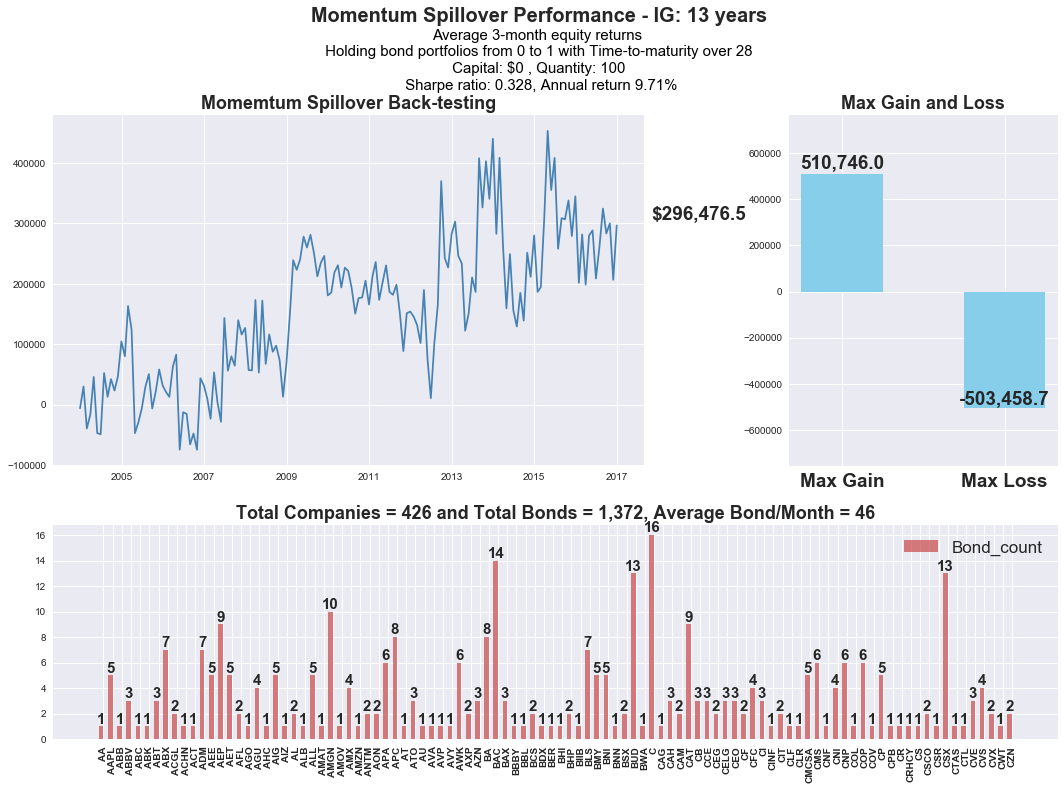

In [18]:
perf_price_IG, list_bond_IG, strat_param_IG, perf_raw_IG = performance_backtest_price(formation_date, data_universe, avg_range, holding_range, test_period, TMT, capital, quantity, fee)
perf_price_plot_IG = performance_backtest_price_plot(perf_price_IG, list_bond_IG, strat_param_IG, data_universe, avg_range, holding_range, test_period, TMT, capital, quantity)

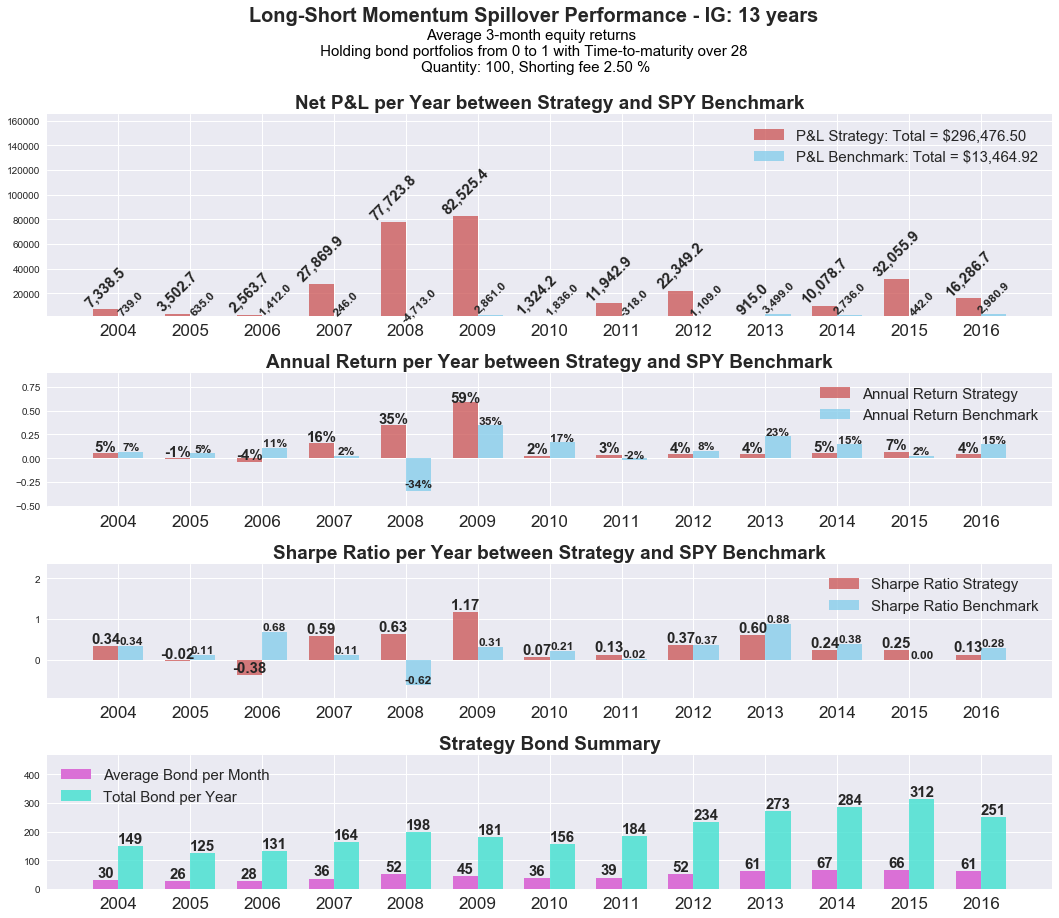

In [35]:
performance_backtest_price_year_plot(perf_raw_IG, list_bond_IG, data_universe, avg_range, holding_range, test_period, TMT, quantity, fee = fee, strat_type = 0)

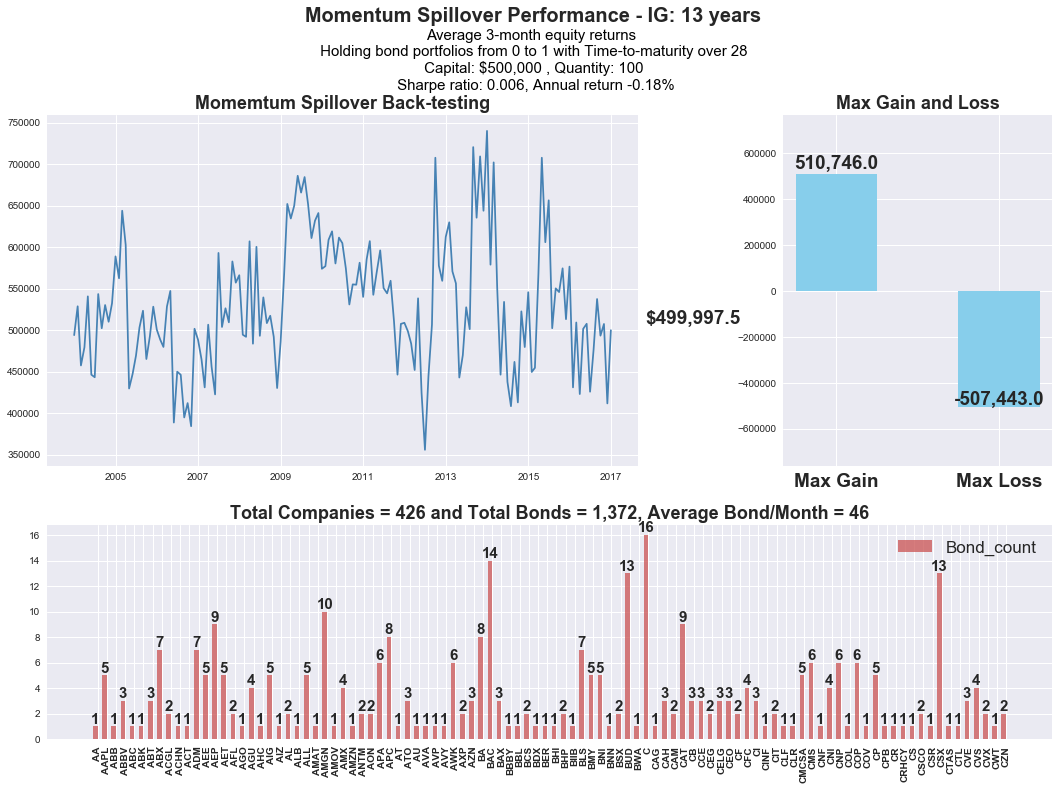

In [38]:
perf_price_IG, list_bond_IG, strat_param_IG = performance_backtest_price(formation_date, data_universe, avg_range, holding_range, test_period, TMT, capital, fee=12.01654/100)
perf_price_plot_IG = performance_backtest_price_plot(perf_price_IG, list_bond_IG, strat_param_IG, data_universe, avg_range, holding_range, test_period, TMT, capital)

# BBB universe

In [32]:
TMT = 29
data_universe = 'BBB'

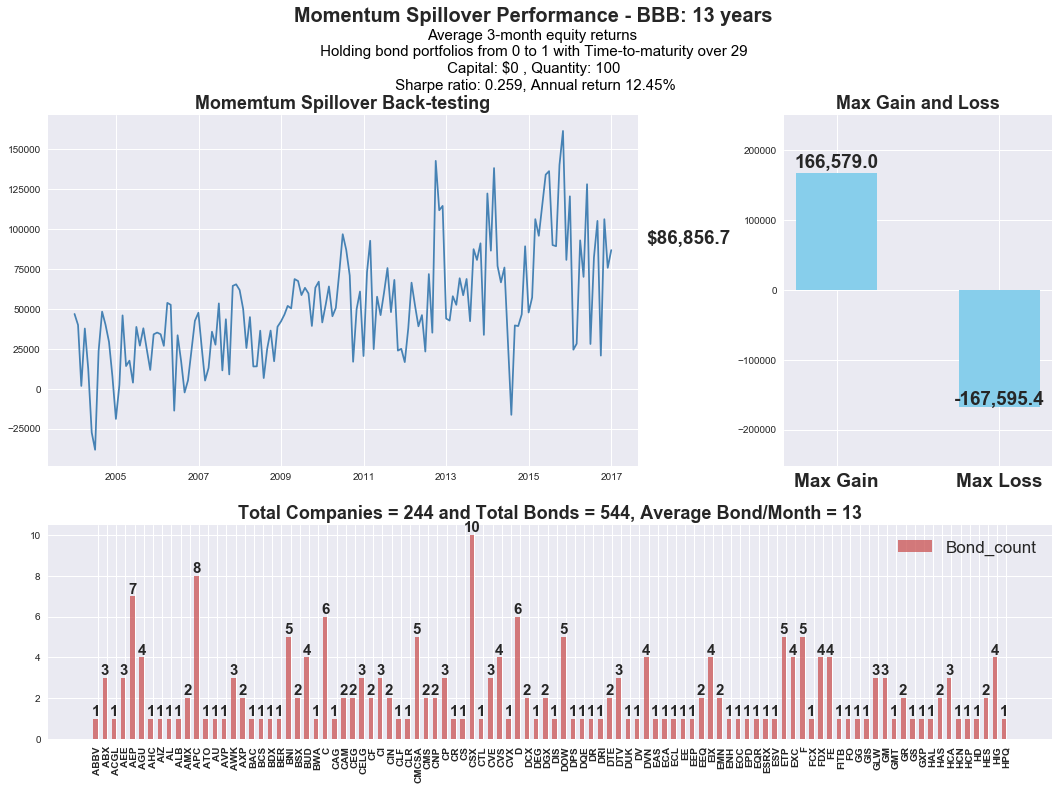

In [21]:
perf_price_BBB, list_bond_BBB, strat_param_BBB, perf_raw_BBB = performance_backtest_price(formation_date, data_universe, avg_range, holding_range, test_period, TMT, capital, quantity, fee)
perf_price_plot_IG = performance_backtest_price_plot(perf_price_BBB, list_bond_BBB, strat_param_BBB, data_universe, avg_range, holding_range, test_period, TMT, capital, quantity)

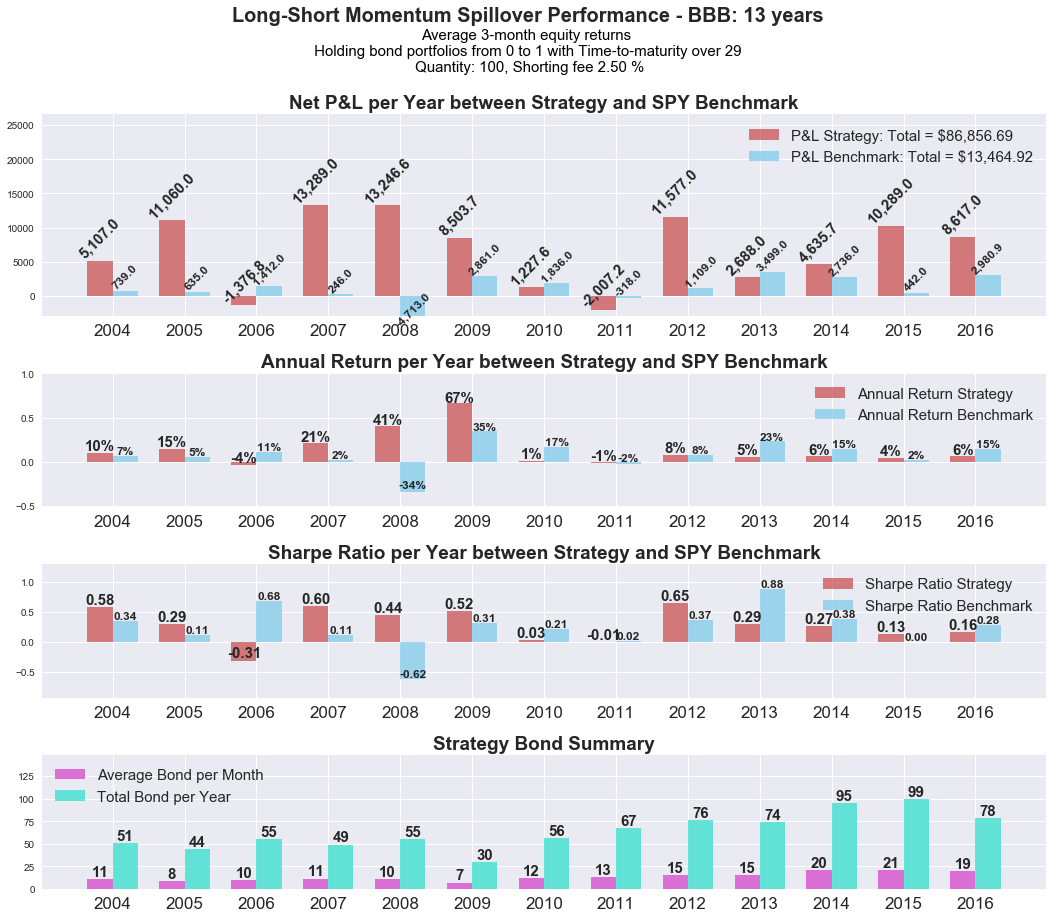

In [33]:
performance_backtest_price_year_plot(perf_raw_BBB, list_bond_BBB, data_universe, avg_range, holding_range, test_period, TMT, quantity, fee = fee, strat_type = 0)

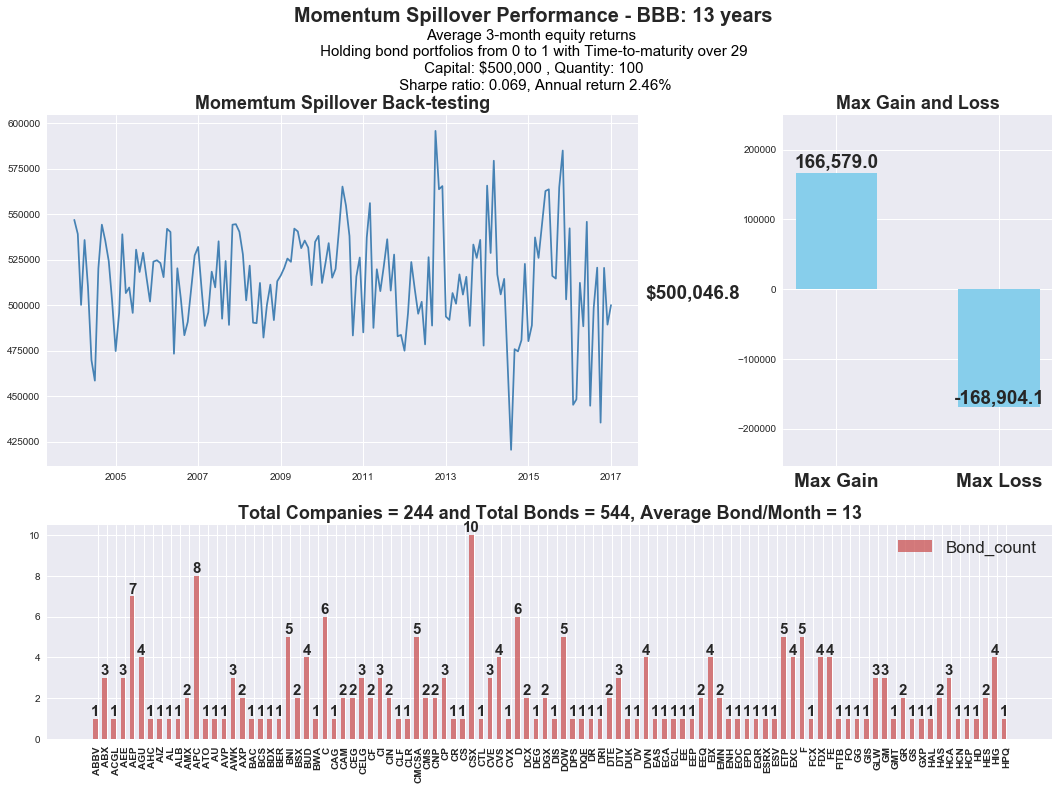

In [18]:
perf_price_BBB, list_bond_BBB, strat_param_BBB = performance_backtest_price(formation_date, data_universe, avg_range, holding_range, test_period, TMT, capital, fee=11.89/100)
perf_price_plot_IG = performance_backtest_price_plot(perf_price_BBB, list_bond_BBB, strat_param_BBB, data_universe, avg_range, holding_range, test_period, TMT, capital)

# HY universe

In [23]:
TMT = 16
data_universe = 'HY'

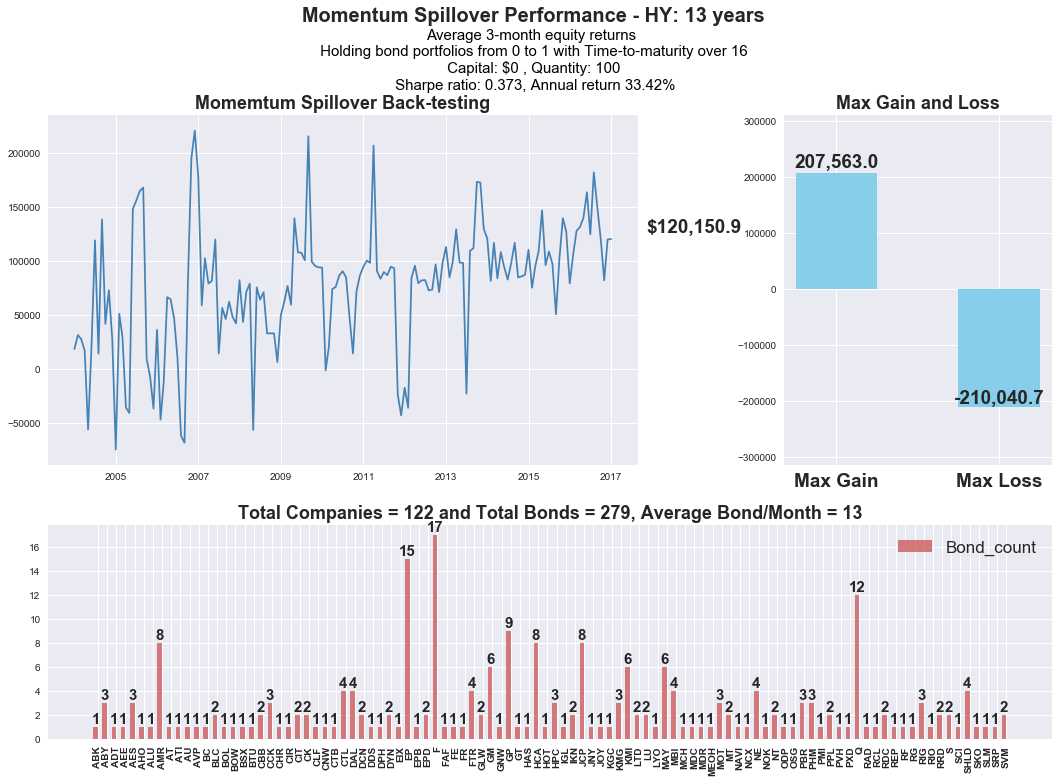

In [24]:
perf_price_HY, list_bond_HY, strat_param_HY, perf_raw_HY = performance_backtest_price(formation_date, data_universe, avg_range, holding_range, test_period, TMT, capital, quantity, fee)
perf_price_plot_HY = performance_backtest_price_plot(perf_price_HY, list_bond_HY, strat_param_HY, data_universe, avg_range, holding_range, test_period, TMT, capital, quantity)

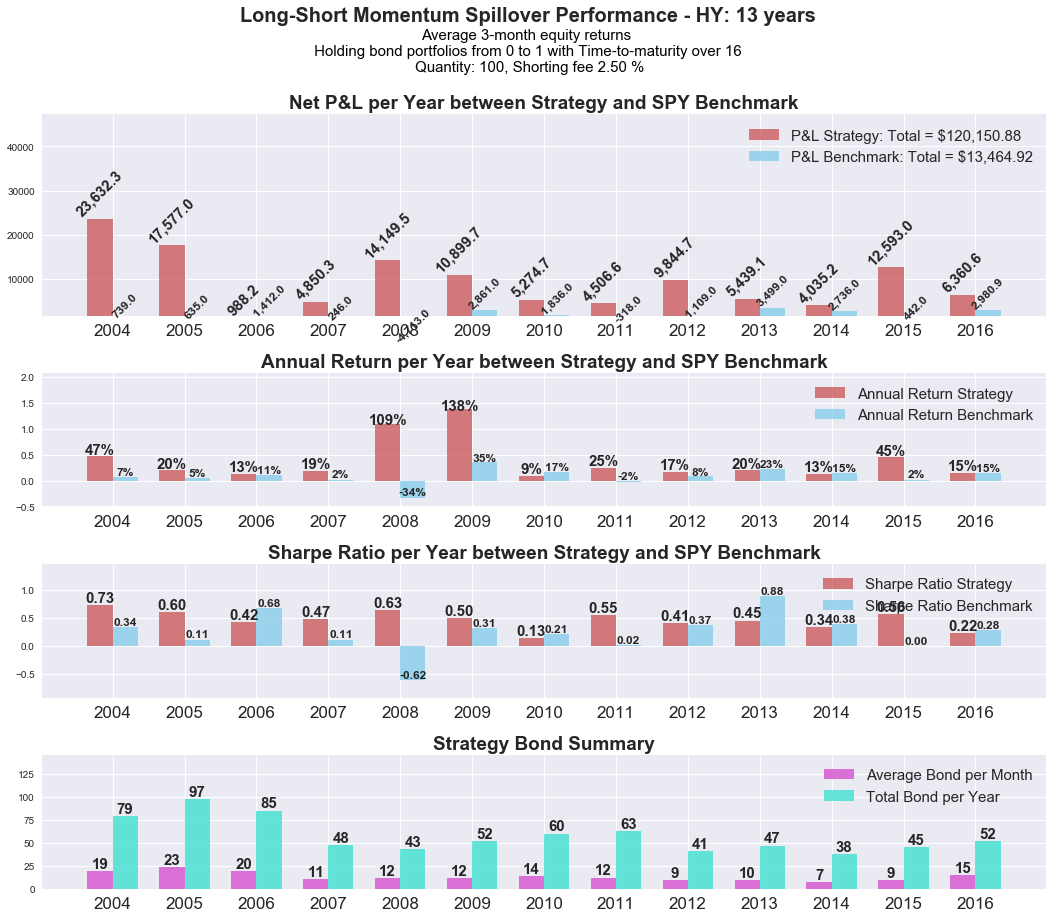

In [31]:
performance_backtest_price_year_plot(perf_raw_HY, list_bond_HY, data_universe, avg_range, holding_range, test_period, TMT, quantity, fee = fee, strat_type = 0)

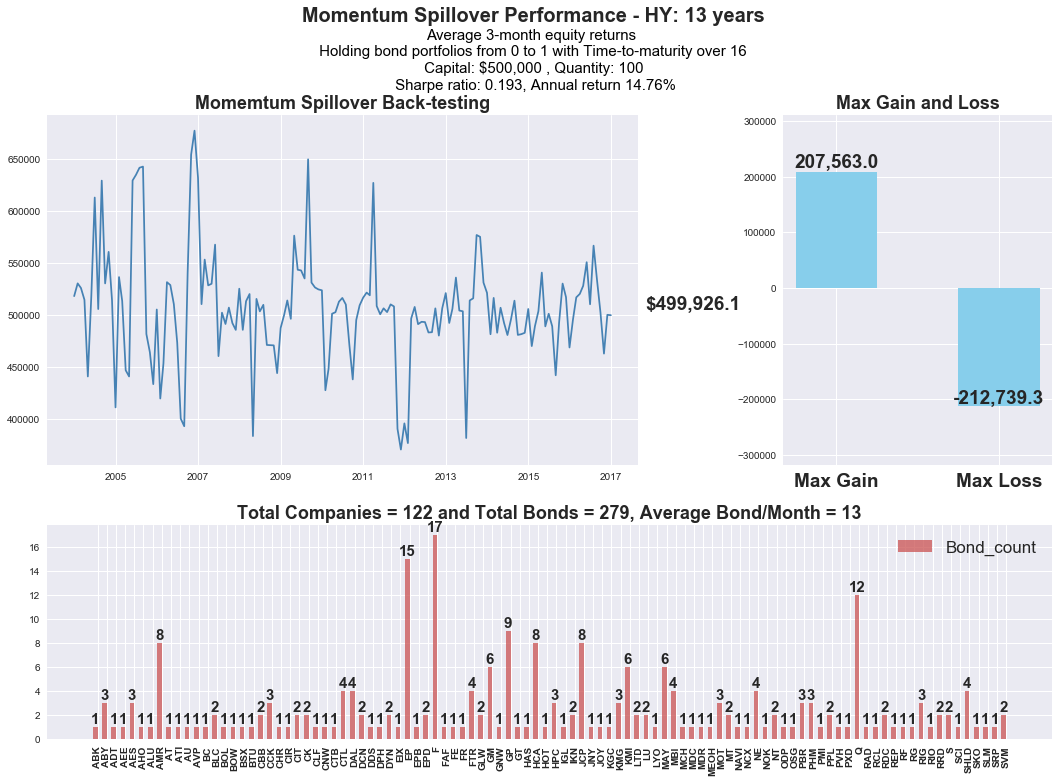

In [24]:
perf_price_HY, list_bond_HY, strat_param_HY = performance_backtest_price(formation_date, data_universe, avg_range, holding_range, test_period, TMT, capital, fee=17.95/100)
perf_price_plot_HY = performance_backtest_price_plot(perf_price_HY, list_bond_HY, strat_param_HY, data_universe, avg_range, holding_range, test_period, TMT, capital)

# Shorting fee: Twofold interest rate

In [16]:
fee = 0

# IG universe

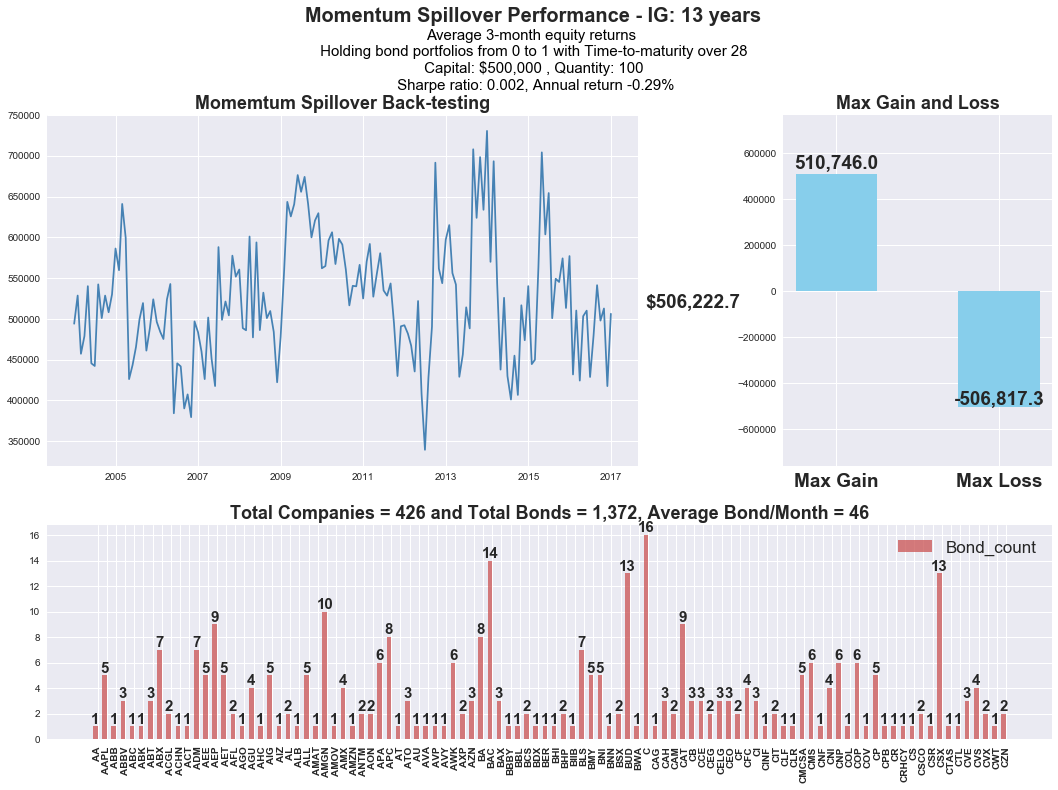

In [17]:
TMT = 28
data_universe = 'IG'
perf_price_IG, list_bond_IG, strat_param_IG = performance_backtest_price(formation_date, data_universe, avg_range, holding_range, test_period, TMT, capital, fee)
perf_price_plot_IG = performance_backtest_price_plot(perf_price_IG, list_bond_IG, strat_param_IG, data_universe, avg_range, holding_range, test_period, TMT, capital)

# BBB universe

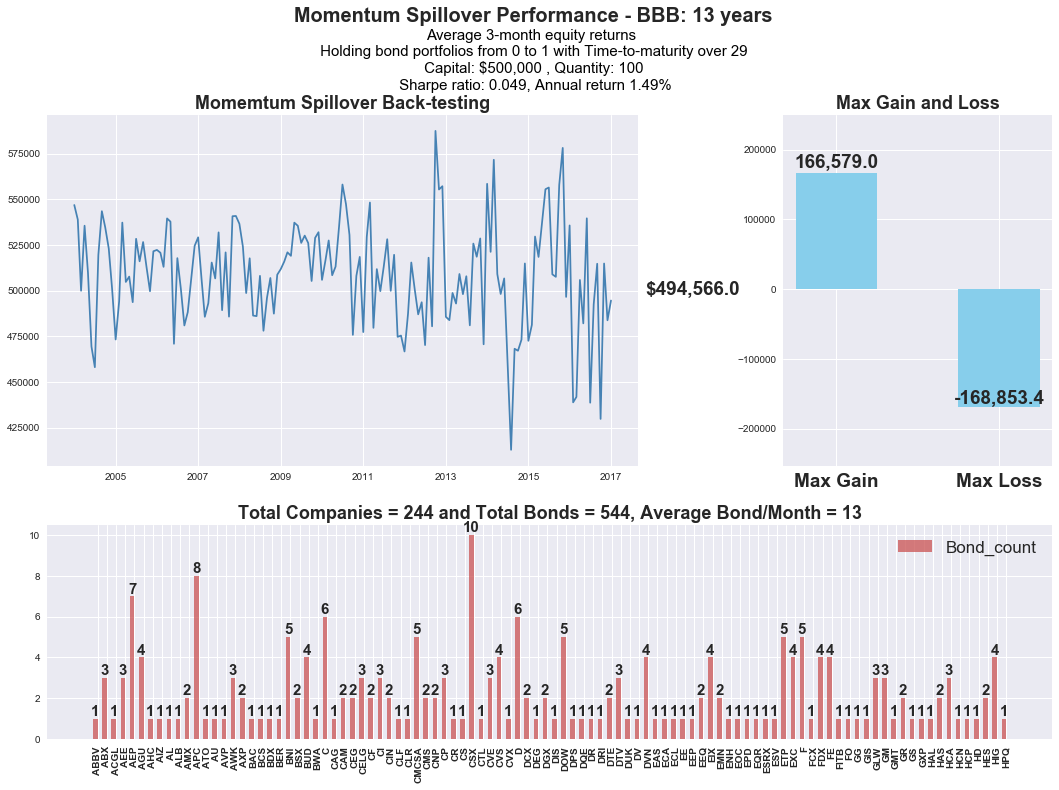

In [18]:
TMT = 29
data_universe = 'BBB'
perf_price_BBB, list_bond_BBB, strat_param_BBB = performance_backtest_price(formation_date, data_universe, avg_range, holding_range, test_period, TMT, capital, fee)
perf_price_plot_IG = performance_backtest_price_plot(perf_price_BBB, list_bond_BBB, strat_param_BBB, data_universe, avg_range, holding_range, test_period, TMT, capital)

# HY universe

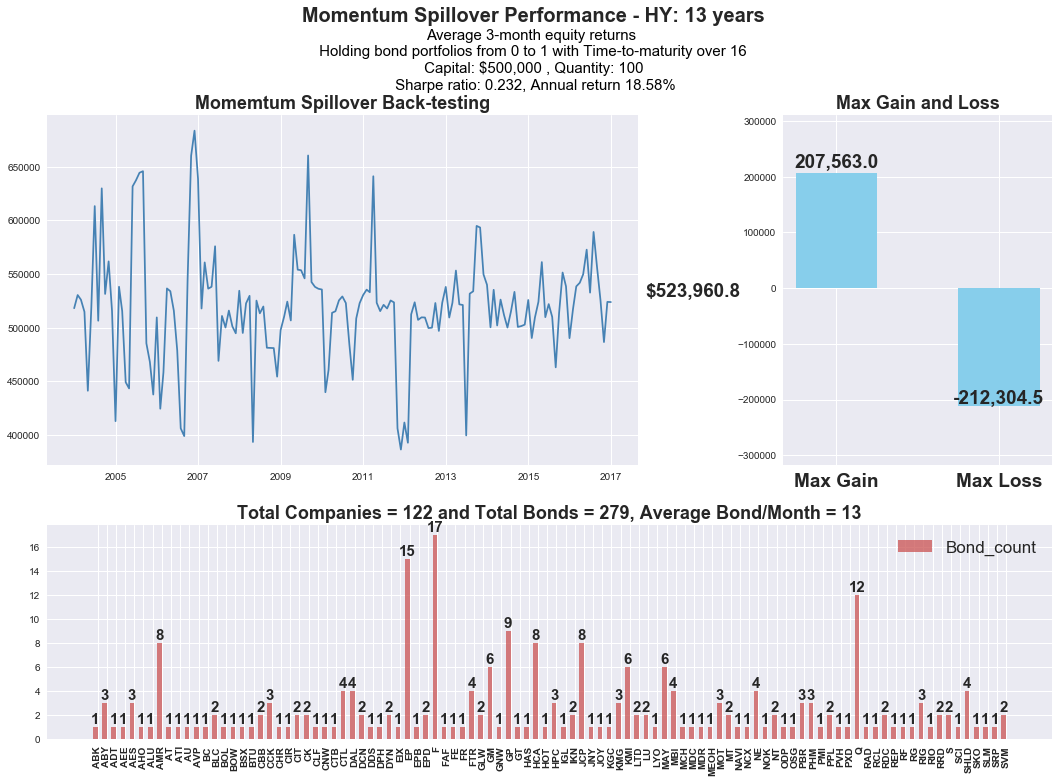

In [19]:
TMT = 16
data_universe = 'HY'
perf_price_HY, list_bond_HY, strat_param_HY = performance_backtest_price(formation_date, data_universe, avg_range, holding_range, test_period, TMT, capital, fee)
perf_price_plot_HY = performance_backtest_price_plot(perf_price_HY, list_bond_HY, strat_param_HY, data_universe, avg_range, holding_range, test_period, TMT, capital)